In [115]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.tree import export_graphviz
import pandas as pd
import numpy as np
import glob
import re
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (20, 15)


train = pd.read_csv('../data/train.csv', index_col='date')
test = pd.read_csv('../data/test.csv', index_col='date')

In [2]:
y_train = train.reel
X_train = train.drop(['reel'], axis=1)
y_test = test.reel
X_test = test.drop(['reel'], axis=1)
X_train.head()

prevision  cantine_nom  annee_scolaire  effectif  quartier_detail  \
date                                                                            
2011-01-03   0.595434    -1.012799        1.087871 -0.269910        -1.091116   
2011-01-03  -0.823041     0.207852       -1.222780 -0.680289         0.488899   
2011-01-03   1.330463    -0.141474       -0.372606 -0.924563         0.678924   
2011-01-03   0.427796    -0.943218       -1.222780  1.127335         0.592007   
2011-01-03   1.382043     3.352224        1.706113 -1.002730        -0.686414   

            prix_quartier_detail_m2_appart  prix_moyen_m2_appartement  \
date                                                                    
2011-01-03                       -0.653145                  -0.408288   
2011-01-03                        1.918779                   2.339611   
2011-01-03                       -0.497418                  -0.675882   
2011-01-03                       -0.035104                  -0.212652   
2011-01-03                        1.750886                   0.790264   

            prix_moyen_m2_maison  longitude  latitude  ...  depuis_juives  \
date                                                   ...                  
2011-01-03             -1.120297   0.774209  2.055271  ...      -1.301284   
2011-01-03              0.535862   0.036838 -0.863408  ...      -1.301284   
2011-01-03              0.238929  -0.720356 -1.375554  ...      -1.301284   
2011-01-03              0.238929   0.139911 -0.048381  ...      -1.301284   
2011-01-03              1.196421   0.655278 -0.086929  ...      -1.301284   

            ramadan_dans  depuis_ramadan      year  day_of_week_sin  \
date                                                                  
2011-01-03       0.74085       -1.461039 -1.563869        -0.019917   
2011-01-03       0.74085       -1.461039 -1.563869        -0.019917   
2011-01-03       0.74085       -1.461039 -1.563869        -0.019917   
2011-01-03       0.74085       -1.461039 -1.563869        -0.019917   
2011-01-03       0.74085       -1.461039 -1.563869        -0.019917   

            day_of_year_sin  day_of_year_cos  week_sin  freq_reel_%  \
date                                                                  
2011-01-03        -0.074069         1.239323  0.015887    -0.399624   
2011-01-03        -0.074069         1.239323  0.015887    -0.082909   
2011-01-03        -0.074069         1.239323  0.015887     1.619386   
2011-01-03        -0.074069         1.239323  0.015887    -1.031682   
2011-01-03        -0.074069         1.239323  0.015887     1.718052   

            freq_reel_%_std  
date                         
2011-01-03        -0.714641  
2011-01-03         1.511968  
2011-01-03        -0.287836  
2011-01-03        -0.927143  
2011-01-03        -0.139540  

[5 rows x 22 columns]

In [3]:
# chargement des meilleurs modèles
models = {}
for model in glob.glob("models/*.sav"):
    loaded_model = pickle.load(open(model, 'rb'))
    name = os.path.basename(model)
    name = os.path.splitext(name)[0]
    models[name] = loaded_model
    
models

{'best_lasso': Lasso(alpha=0.01, random_state=62),
 'best_lgbr': LGBMRegressor(max_depth=5, n_estimators=150, num_leaves=8),
 'best_elastic': ElasticNet(alpha=0.1, l1_ratio=0.8),
 'best_lassol': LassoLars(alpha=0.00076),
 'best_rfr': RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=50,
                       n_estimators=300, random_state=42),
 'best_mlpr': MLPRegressor(alpha=1, batch_size=50, epsilon=1e-05, hidden_layer_sizes=(64,),
              learning_rate='adaptive', max_iter=1000, random_state=42,
              warm_start=True),
 'best_dtr': DecisionTreeRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=10,
                       min_weight_fraction_leaf=0.1, random_state=42),
 'best_xgbr': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=

Ici, afin d'avoir différents axes d'interprétation, nous allons analyser différents modèles :
- lasso
- random forest
- lightgbm
- xgboost

## Analyse de l'importance des features

### 1. Lasso

In [21]:
lasso_coef = pd.Series(models['best_lasso'].coef_, index=X_train.columns)
lasso_coef[lasso_coef > 0].sort_values(ascending=False)

prevision          2.789916
annee_scolaire     0.031018
cantine_nom        0.025376
day_of_year_cos    0.011424
depuis_ferie       0.007695
quartier_detail    0.007487
ramadan_dans       0.003034
depuis_ramadan     0.001943
dtype: float64

Lasso a clairement mis me focus sur la variable prevision, mais il est intéressant d'observer la relative importance des features temporelles et géographiques.

### 2. Random forest

In [66]:
decision_tree_100 = models['best_rfr'].estimators_[100]

# Export as dot file
export_graphviz(decision_tree_100, 
                out_file='tree.dot', 
                feature_names = list(X_train.columns),
                class_names = 'Fréquentation',
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=4)

In [67]:
# Convert to png
from subprocess import call

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [68]:
# Display in jupyter notebook
from IPython.display import Image

Image(filename = 'tree.png')

De même que pour lasso, pour le 100ème arbre de décision de notre forêt aléatoire, on constate que "prevision" est la feature dominante quand aux décisions prises. Ici, les features sont standardisées, ainsi, les valeurs ne sont pas significatives. Cependant, on observe la manière dont notre arbre dispatche les données dans chaque bucket, split après split. Il faut attendre le 4ème split pour voir la feature latitude jouer un rôle dans la régression.


### 3. Xgboost


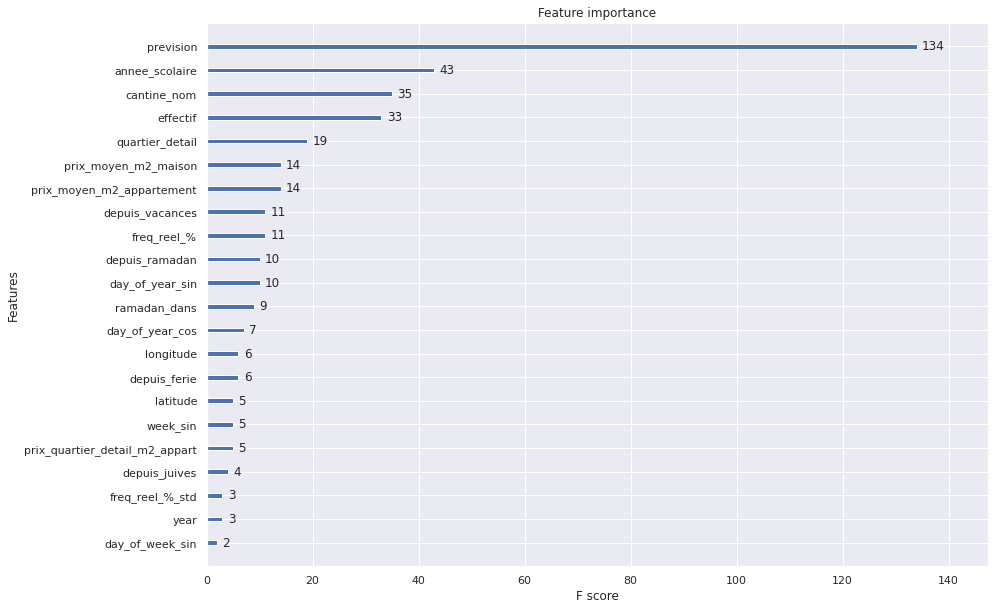

Les conclusions sont ici similaires à celle de Lasso, sauf le modèle laisse davantage de place aux features secondaires. On observer une forte présence des features géographiques aux bonnes places. Cela fait sens car elles permettent de différencier les cantines dans ce modèle aggrégé. De plus la temporalité est déjà capturée par le caractère ordinal des données. Si l'on développe un modèle par cantine, nous pourrons certainement observer l'impact d'autres features que les features géographiques (menus, temporelles, statistiques...)

In [78]:
# import xgboost as xgb

# models['best_xgbr'].get_booster().feature_names = list(X_train.columns)
# plt.rcParams["figure.figsize"] = (14, 10)
# xgb.plot_importance(models['best_xgbr'].get_booster());

### 4. LightGBM 

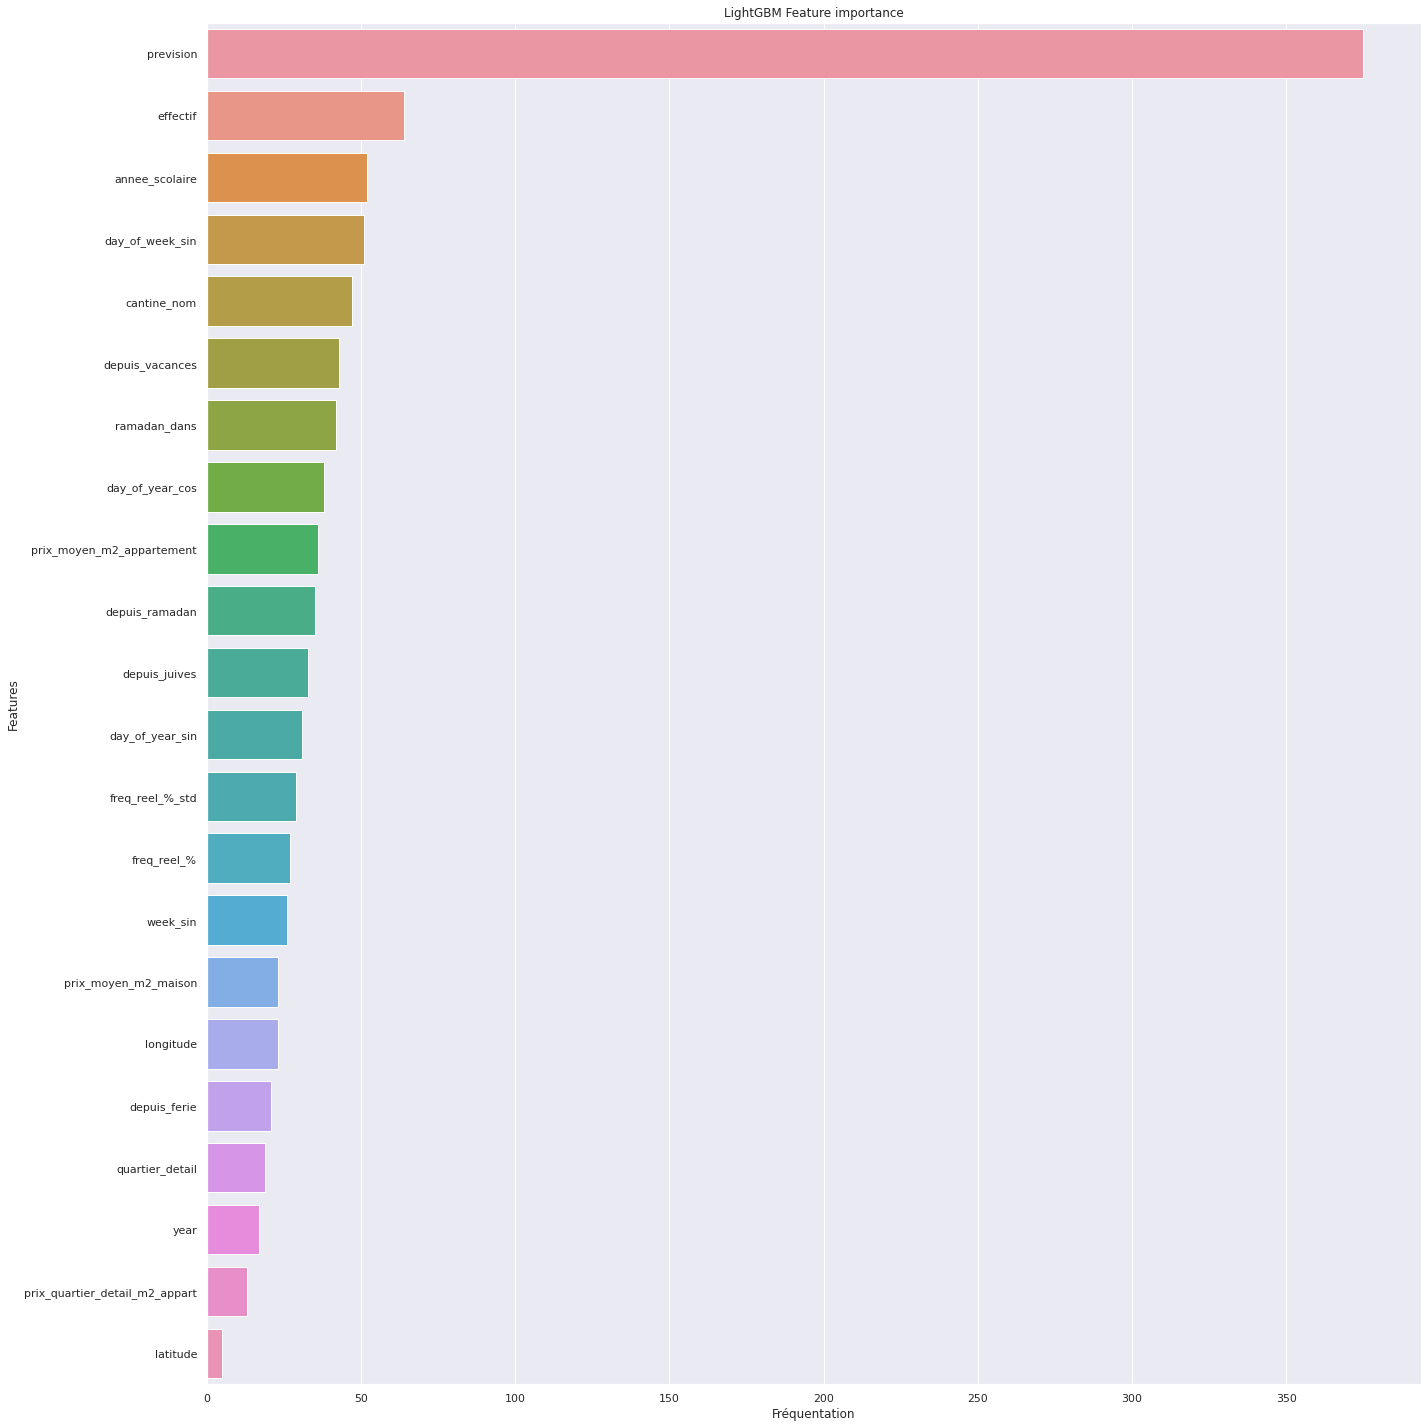

In [112]:
feature_imp = pd.DataFrame(sorted(zip(models['best_lgbr'].feature_importances_, list(
    X_train.columns))), columns=['Fréquentation', 'Features'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Fréquentation", y="Features", data=feature_imp.sort_values(
    by="Fréquentation", ascending=False))
plt.title('LightGBM Feature importance')
plt.tight_layout()
plt.show()

Light GBM favorise "prevision" comme tous les autres modèles. Cependant, on peut noter que contrairement à Xgboost, on retrouve davantage de features temporelles aux premiers rangs (day_of_week, ramadan_dans, day_of_year...). Ce sont des modèles similaires (arbres de décision boostés) mais néanmoins leur implémentation variant, ils prennent des décisions différentes.



## Analyse des courbes d'apprentissage


Les courbes d'apprentissage sont un outil de diagnostic largement utilisé en apprentissage automatique pour les algorithmes qui apprennent de manière incrémentielle à partir d'un ensemble de données d'apprentissage. Le modèle peut être évalué sur l'ensemble de données d'apprentissage et sur un ensemble de données de validation après chaque mise à jour pendant l'apprentissage et des graphiques des performances mesurées peuvent être créés pour montrer les courbes d'apprentissage.

L'examen des courbes d'apprentissage des modèles pendant l'entraînement peut être utilisé pour diagnostiquer les problèmes d'apprentissage, tels qu'un modèle sous-entraîné ou sur-entraîné, ainsi que pour déterminer si les ensembles de données de formation et de validation sont suffisamment représentatifs.


In [86]:
def plot_learning_curve(estimator, title,
                        X, y, ylim=None, cv=None,
                        n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate the learning curves of the given estimator for 10 training sizes"""

    plt.figure(figsize=(10, 8))
    plt.title(title)

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Nb of training examples")
    plt.ylabel("Scores")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="CV score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/quentin/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

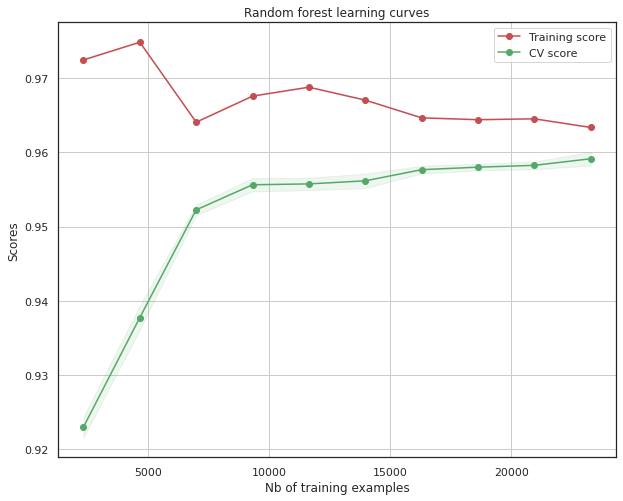

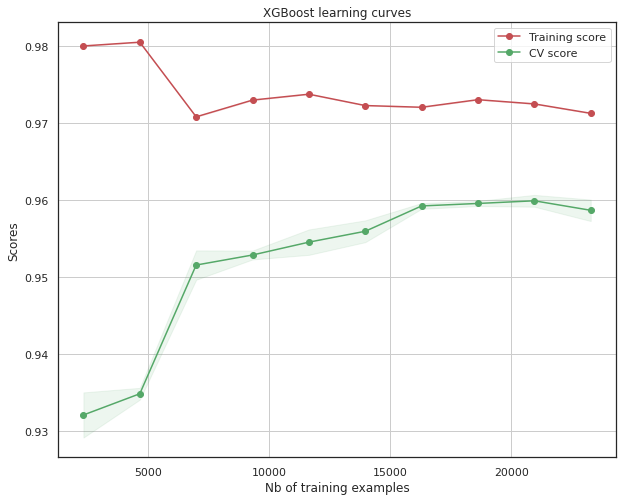

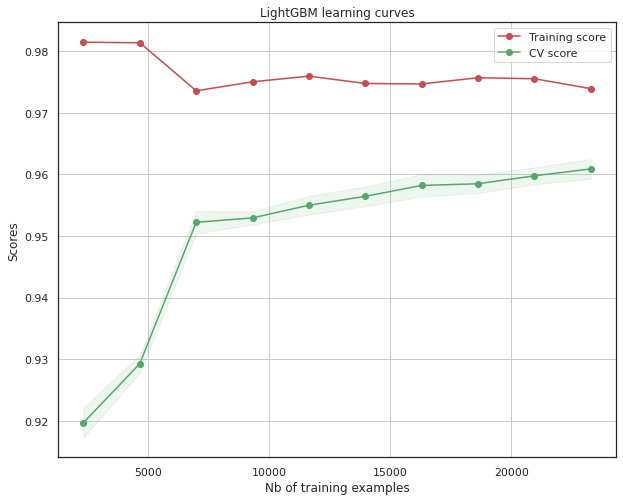

In [93]:
# doing the time series split for this specific dataset
# this will prevent any data leakage where we predict past values with future ones
from sklearn.model_selection import TimeSeriesSplit
cv_ts = TimeSeriesSplit(n_splits=2)

plot_learning_curve(models['best_rfr'], "Random forest learning curves", X_train, y_train, cv=cv_ts)
plot_learning_curve(models['best_xgbr'], "XGBoost learning curves", X_train, y_train, cv=cv_ts)
plot_learning_curve(models['best_lgbr'], "LightGBM learning curves", X_train, y_train, cv=cv_ts)

Les courbes d'apprentissage semblent bonnes. En effet, on observe une convergence entre les courbes des jeux d'entraînement et de validation et cela à un bon niveau de précision.

## Analyse des prédictions du modèle retenu (LGBM)

In [96]:
y_pred = models['best_lgbr'].predict(X_test)

df_predictions = pd.DataFrame(
    y_pred**2, index=y_test.index, columns=['predictions'])
frames = [df_predictions, y_test**2]
results = pd.concat(frames, axis=1)

In [97]:
results.head()

predictions        reel
date                               
2018-09-03   109.232053  111.000005
2018-09-03   204.106957  238.000012
2018-09-03   120.006166  125.999996
2018-09-03   248.779591  217.000004
2018-09-03   248.209528  196.999976

In [104]:
# Erreur moyenne
mean_error = round(np.mean(results['reel']-results['predictions'])*100.0/np.mean(results['reel']),2)
print(f'Erreur moyenne du modèle: {mean_error}%')

Erreur moyenne du modèle: 6.41%


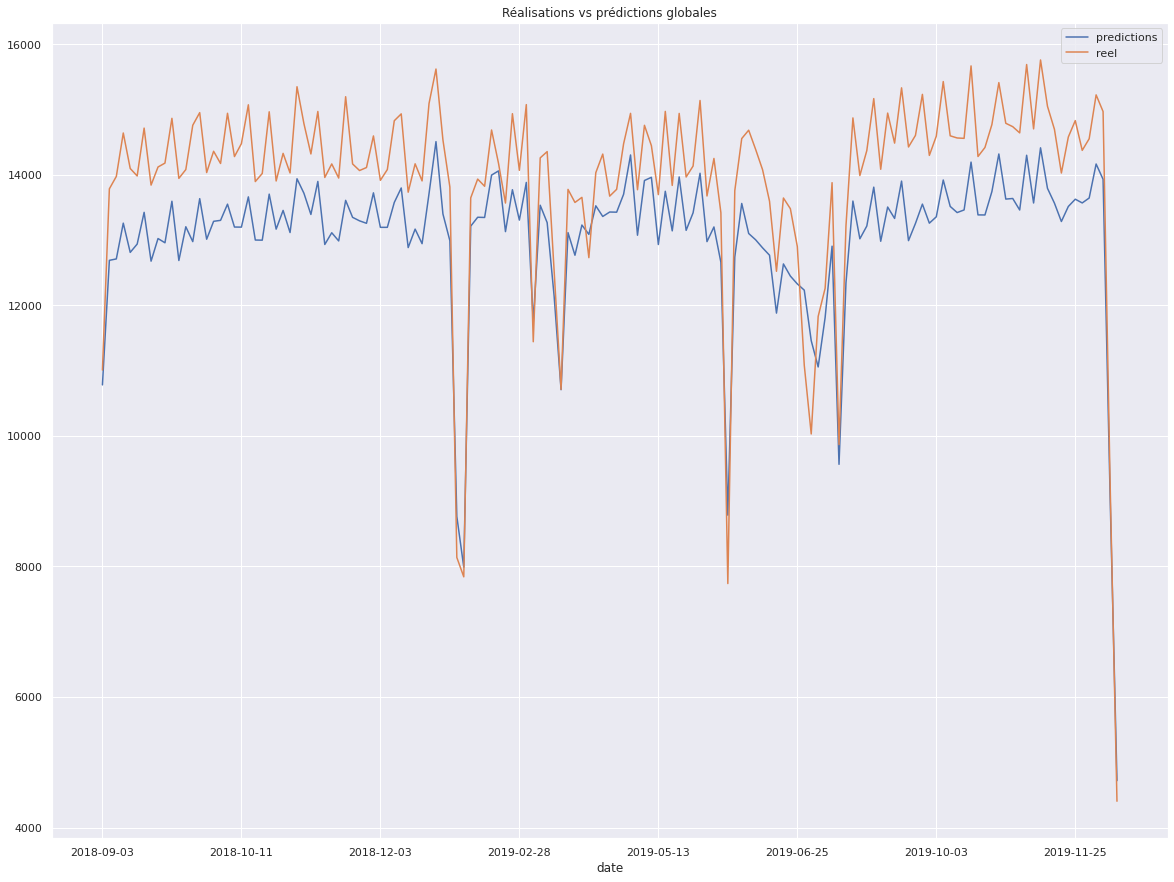

In [116]:
plt.title('Réalisations vs prédictions globales')
agg = results.groupby(results.index)[['predictions', 'reel']].sum()
for col in ['predictions', 'reel']:
    agg[col].plot(legend=True)
plt.show()

On voit clairement que notre modèle est bon à capturer la tendance dans l'évolution des fréquentations, cependant il sous évalue presque systématiquement le volume de ces dernières.


## Analyse des erreurs du modèles

Pour continuer l'évaluation de la performance du modèle, il convient d'analyser la distribution des résidus. Si cette distribution ne suit pas une loi normale, cela signifie qu'il reste de l'information non capturée par le modèle dans ces résidus.

/home/quentin/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


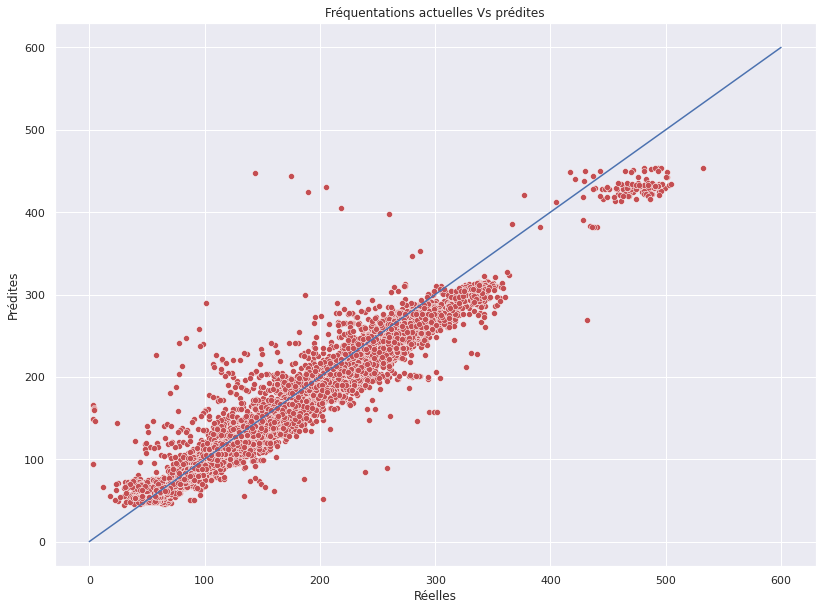

In [122]:
# Check Actual value Vs Predicted value
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(121)
sns.scatterplot(y_test**2,y_pred**2,ax=ax,color='r')
ax.set_title('Fréquentations actuelles Vs prédites');
plt.xlabel('Réelles')
plt.ylabel('Prédites')
    
plt.plot( [0,600],[0,600]);

Les prédictions sous évaluent souvent la fréquentation réelle. Malgré la présence de quelques outliers importants.
On constate cela encore davantage pour les valeurs de fréquentation importantes (400 et plus).

/home/quentin/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


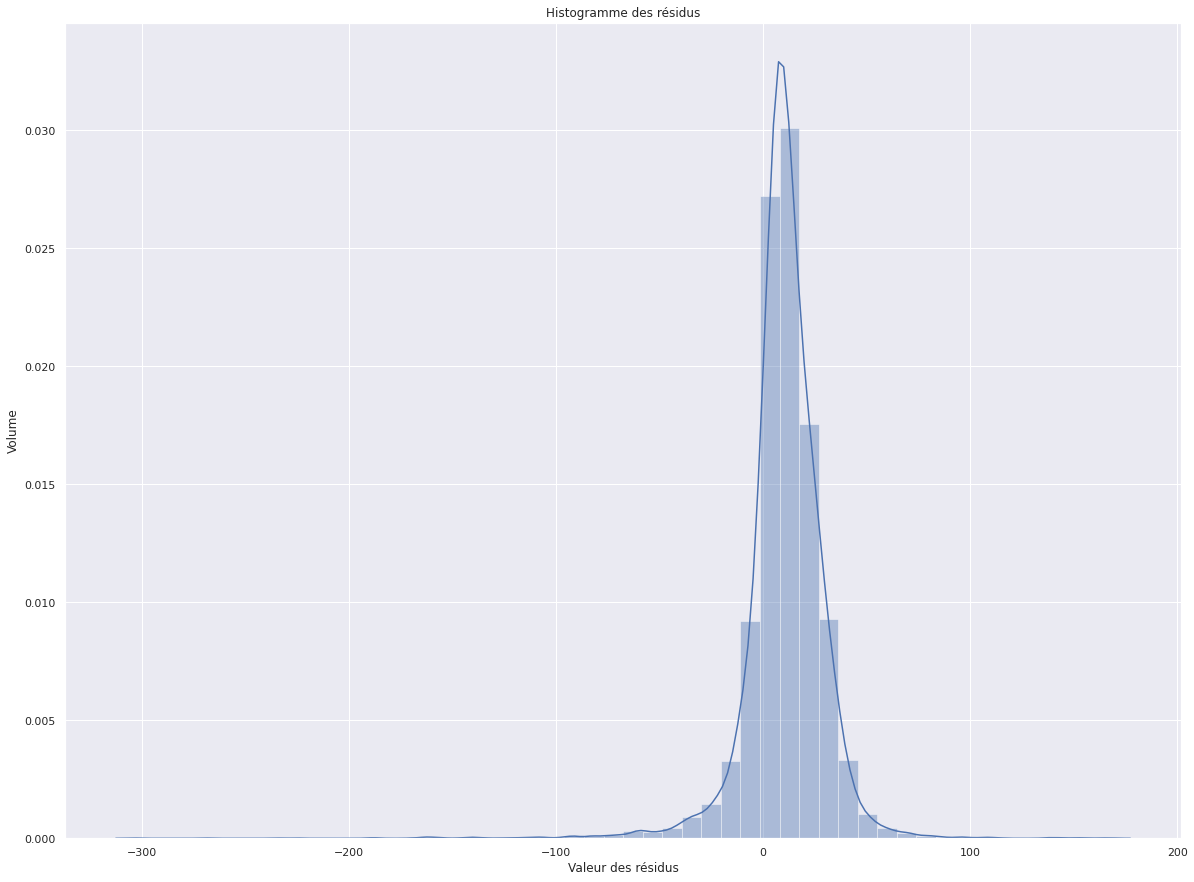

In [124]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.values.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogramme des résidus')
    plt.xlabel('Valeur des résidus')
    plt.ylabel('Volume')
    
hist_resids(y_test**2, y_pred**2)    

Cet histogramme montre qu'il y a une distorsion notable dans la distribution. y_test - y_pred est souvent positif, cela signifie que notre modele sous évalue assez régulièrement la fréquentation des cantines. On note aussi la présence de quelques valeurs abérantes qui tirent la RMSE vers le haut.

Ensuite, voyons cela sur un QQ plot. 

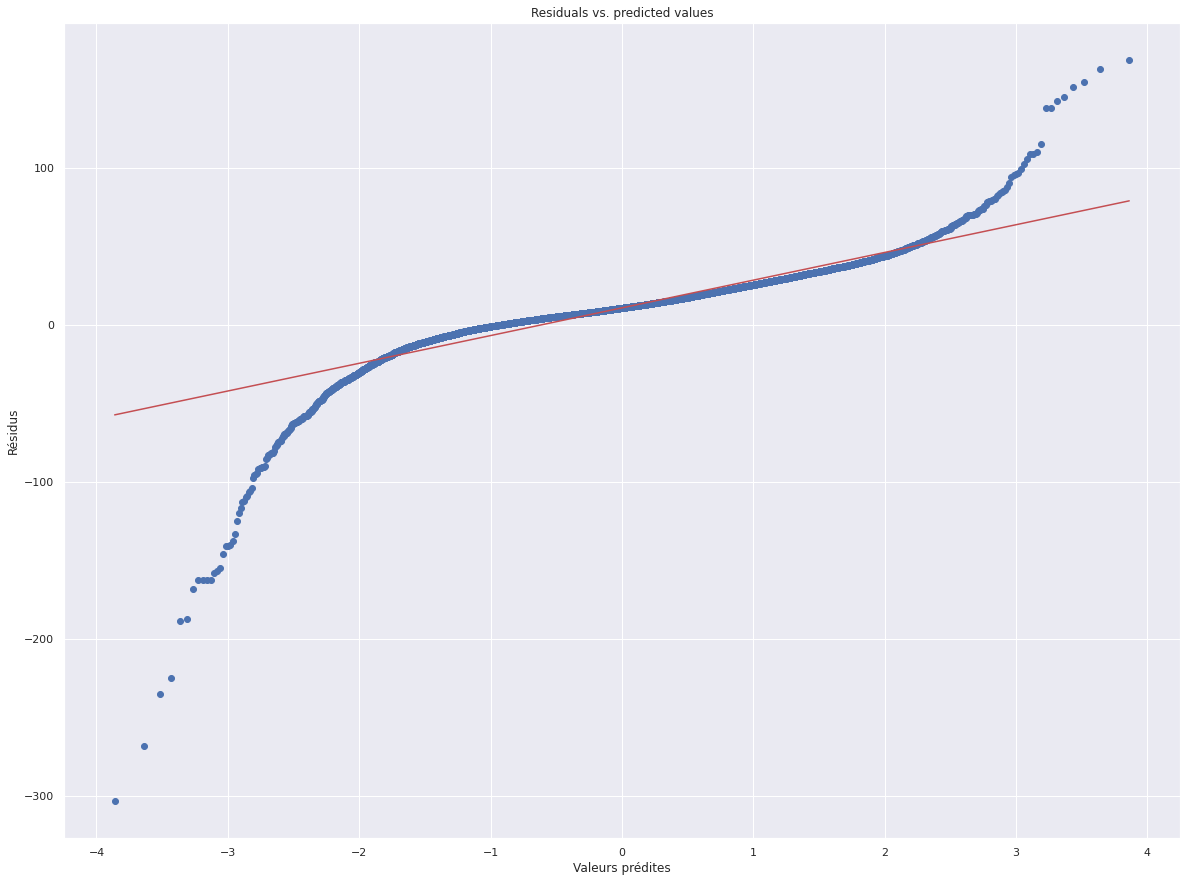

In [127]:
def resid_qq(y_test, y_score):
    import scipy.stats as ss
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.values.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Résidus')
    
resid_qq(y_test**2, y_pred**2) 

Et sur un residual plot.

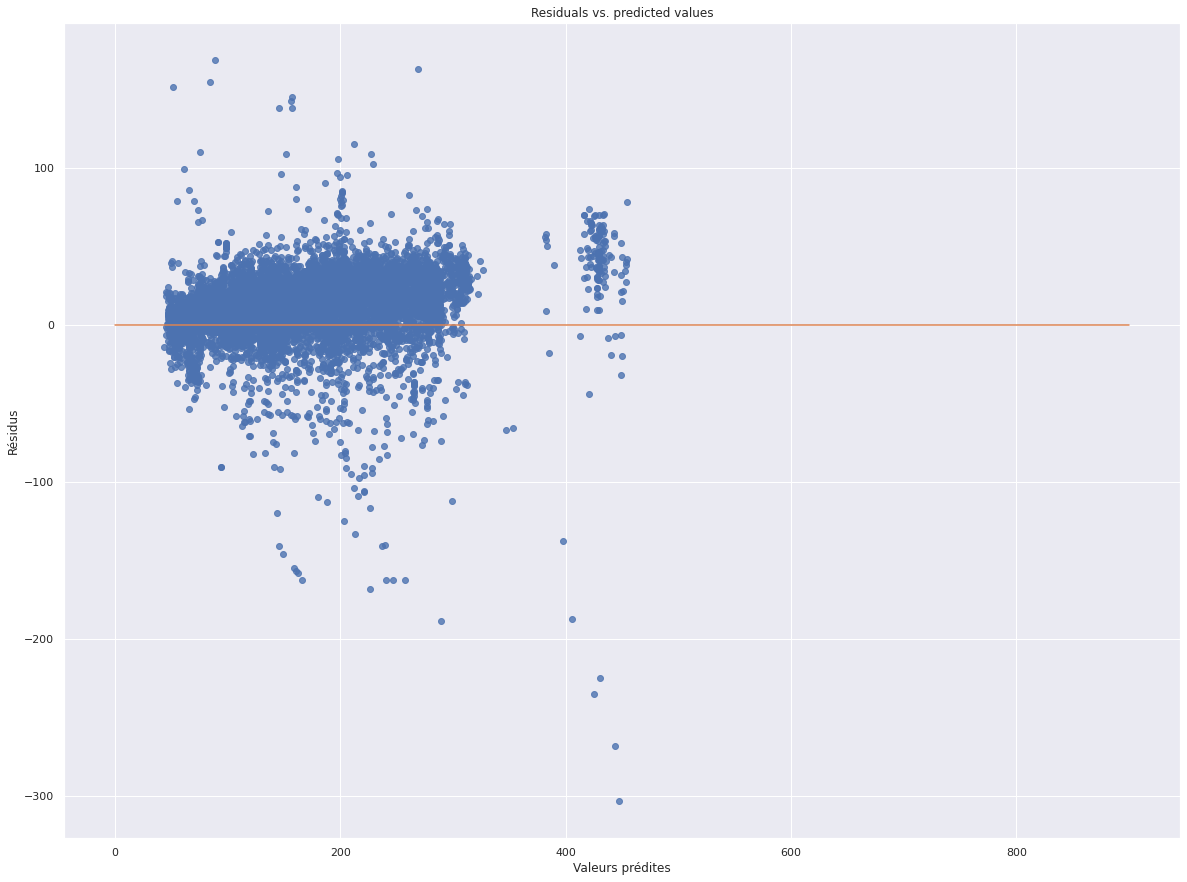

In [129]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.values.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Résidus')
    plt.plot([0,900],[0,0]);
    
resid_plot(y_test**2, y_pred**2) 

Il apparaît que les résidus sont hétéroscédastiques. Cela signifie que la variance de l'erreur n'est pas constante pour les différents niveaux de la fréquentation. En effet, les résidus sont globalement positifs (ie. y_test > y_pred) jusqu'à 400-500 puis ensuite, on observer la présence de quelques importants résidus négatifs Par conséquent, la signification statistique des variables indépendantes peut être surestimée ou sous-estimée (les coefficients de lasso, par exemple).

De cette analyse, il apparait clairement qu'il faudrait se passer de quelques outliers supplémentaires dans notre fonction basée sur le z-score. De plus, il faut se pencher sur un moyen de régler cette sous évaluation chronique avant des niveaux de fréquentation de 500 et plus.

Ainsi, un modèle entrainé pour chaque cantine permettrait certainement d'améliorer la qualité des prédictions.